In [1]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unrar x "/content/drive/MyDrive/data_1min_p.rar" "/content/content/data_1min/"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/data_1min_p.rar

Creating    /content/content                                          OK
Creating    /content/content/data_1min                                OK
Extracting  /content/content/data_1min/TONUSDT.pickle                      0%  1%  OK 
Extracting  /content/content/data_1min/ETHUSDT.pickle                      2%  3%  OK 
Extracting  /content/content/data_1min/EIGENUSDT.pickle                    3%  4%  OK 
Extracting  /content/content/data_1min/ARBUSDT.pickle                      5%  OK 
Extracting  /content/content/data_1min/PENGUUSDT.pickle                    6%  7%  OK 
Extracting  /content/content/data_1min/ENAUSDT.pickle                      8%  OK 
Extracting  /content/content/data_1min/1000BONKUSDT.pickle                 9% 10%  OK 
Extracting  /content/content/data_1min

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Loading OHLCV of multi stocks

In [4]:
import os
# data_crypto_path = '/content/content2/'
# list_crypto = [x[5:-4] for x in os.listdir(data_crypto_path) if 'data_' in x and 'FORMUSDT' not in x]

data_crypto_path = '/content/content/data_1min/'
list_crypto = [x[:-7] for x in os.listdir(data_crypto_path)]
# list_crypto = list_crypto[4:10]
# list_crypto = list_crypto[:10] + list_crypto[-10:]
len(list_crypto)

75

Loading Embeded news based on bigbird

In [ ]:
df_news_main = pd.read_pickle('/content/drive/MyDrive/news.pickle')

dfff = df_news_main[[x[:-4] for x in list_crypto if x[:-4] in df_news_main.columns]].sum().sort_values(ascending=False).iloc[:30]
list_crypto = list(dfff.index)
list_crypto = [x+'USDT' for x in list_crypto]

df_news_main['news_count'] = df_news_main[[x[:-4] for x in list_crypto]].sum(axis=1)
df_news_main = df_news_main[df_news_main['news_count']>0].copy()
df_news_main

Get No news Embedding

In [5]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# === Config ===
MODEL_PATH = "/content/drive/MyDrive/ColabModels/bigbird-2048-final"
BATCH_SIZE = 32
MAX_LEN = 2048
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load model & tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModel.from_pretrained(MODEL_PATH).to(DEVICE)
model.eval()  # No dropout

# === Embedding function ===
def get_embeddings(texts):
    """Tokenize and get embeddings for a batch of texts."""
    enc = tokenizer(
        texts,
        truncation=True,
        padding="max_length",  # Ensures same shape for batching
        max_length=MAX_LEN,
        return_tensors="pt"
    )
    enc = {k: v.to(DEVICE) for k, v in enc.items()}

    with torch.no_grad():
        outputs = model(**enc)
        # Use CLS token embedding (first token)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu()
    return embeddings


no_news_embedding = get_embeddings(["no news at this time"]).cpu().numpy()[0]

Preparing embedding of news (Handling multi news and no news)

In [9]:
import pandas as pd
import numpy as np

def _parse_to_dt(s):
    """Parse timestamps; handles ms-epoch or datetime-like strings."""
    # try ms epoch first
    dt_ms = pd.to_datetime(s, unit="ms", errors="coerce")
    if getattr(dt_ms, "notna", lambda: False)().mean() > 0.9:
        return dt_ms
    return pd.to_datetime(s, errors="coerce")

def _avg_embeddings(series):
    """Average a Series of embeddings (lists/np arrays) into one np array."""
    arrs = []
    for x in series:
        if x is None:
            continue
        if isinstance(x, (list, tuple)):
            x = np.asarray(x, dtype=float)
        elif isinstance(x, np.ndarray):
            x = x.astype(float, copy=False)
        else:
            # skip non-array values
            continue
        arrs.append(x)
    if not arrs:
        return None
    # Ensure same length
    lens = {a.shape for a in arrs}
    if len(lens) != 1:
        raise ValueError(f"Embedding length mismatch in group: shapes={lens}")
    return np.mean(np.stack(arrs, axis=0), axis=0)

def resample_news_to_3min(df_news, no_news_embedding, rule="3T"):
    """
    Resample df_news to 3-min bins:
      - embedding: mean over bin
      - per-asset columns (0/1): sum -> count of related news per asset
      - news_count: sum if present; else group size
    Returns a DataFrame indexed by 3-min timestamps with filled 'no news' rows.
    """
    df = df_news.copy()

    # Identify columns
    base_cols = {"releasedAt", "embedding", "news_count"}
    # infer asset columns as 0/1 flags (all the rest)
    asset_cols = [c for c in df.columns if c not in base_cols]

    # Parse releasedAt and floor to 3-min
    df["releasedAt"] = _parse_to_dt(df["releasedAt"])
    df = df.dropna(subset=["releasedAt"])
    df["t3"] = df["releasedAt"].dt.floor(rule)
    df = df.sort_values("t3")

    # Build aggregation dict
    agg_dict = {c: "sum" for c in asset_cols}  # counts per asset
    if "news_count" in df.columns:
        agg_dict["news_count"] = "sum"

    # Group and aggregate
    g = df.groupby("t3", sort=True)
    news_agg = g.agg(agg_dict)
    # If news_count not provided, use group size as total count
    if "news_count" not in news_agg.columns:
        news_agg["news_count"] = g.size()

    # Embedding: custom mean
    emb_mean = g["embedding"].apply(_avg_embeddings)
    news_agg = news_agg.join(emb_mean.rename("embedding"))

    # Ensure integer dtype for asset counts
    for c in asset_cols:
        if c in news_agg.columns:
            news_agg[c] = news_agg[c].fillna(0).astype(int)

    # Fill missing bins **within the observed range** (optional; often we reindex to market later)
    full_index = pd.date_range(news_agg.index.min(), news_agg.index.max(), freq=rule)
    news_agg = news_agg.reindex(full_index)

    # Fill 'no news' bins: zero counts, no_news_embedding
    news_agg["news_count"] = news_agg["news_count"].fillna(0).astype(int)
    for c in asset_cols:
        news_agg[c] = news_agg[c].fillna(0).astype(int)

    # Fill embeddings where NaN with the provided no-news vector
    if no_news_embedding is None:
        raise ValueError("no_news_embedding must be provided (list or np.array).")
    no_news_embedding = np.asarray(no_news_embedding, dtype=float)
    mask = news_agg["embedding"].isna()
    news_agg.loc[mask, "embedding"] = news_agg.loc[mask, "embedding"].apply(
        lambda _: np.asarray(no_news_embedding, dtype=float).copy()
    )


    news_agg.index.name = "t3"
    return news_agg

def merge_news_into_market(df_market, news_3m, rule="3T", date_col="dateTime"):
    """
    Merge resampled news into market dataframe on 3-min bins.
    - df_market[date_col] can be ms-epoch or datetime-like; we floor to 3T.
    - Returns df_market with added columns: embedding, news_count, and per-asset counts.
    """
    dm = df_market.copy()

    # Parse/normalize market times → 3-min bins
    if not np.issubdtype(dm[date_col].dtype, np.datetime64):
        dt_ms = pd.to_datetime(dm[date_col], unit="ms", errors="coerce")
        if dt_ms.notna().mean() > 0.9:
            dm[date_col] = dt_ms
        else:
            dm[date_col] = pd.to_datetime(dm[date_col], errors="coerce")
    dm = dm.dropna(subset=[date_col]).sort_values(date_col)
    dm["t3"] = dm[date_col].dt.floor(rule)

    # Reindex news to exactly the market timestamps so every market row gets a match
    needed_index = dm["t3"].unique()
    news_for_market = news_3m.reindex(needed_index)

    # (Safety) Any remaining missing embeddings -> fill with first non-null or leave None
    if news_for_market["embedding"].isna().any():
        # better to leave them NaN if you want to detect them later
        pass

    # Merge
    out = dm.merge(
        news_for_market.reset_index().rename(columns={"t3": "t3_news"}),
        left_on="t3",
        right_on="t3_news",
        how="left",
        suffixes=("", "_news"),
    ).drop(columns=["t3_news"])

    return out

# ----------------------
# Usage:
# news_3m = resample_news_to_3min(df_news, no_news_embedding, rule="3T")
# merged  = merge_news_into_market(df_market, news_3m, rule="3T", date_col="dateTime")


In [ ]:
df_news = df_news_main[['releasedAt','embedding','news_count']+[x[:-4] for x in list_crypto]].copy()
news_3m = resample_news_to_3min(df_news, no_news_embedding, rule="3T")

Preprocessing OHLCV

In [13]:
list_data = []
shifted_window = 80
selected_f_asset = ['open', 'high', 'low', 'close', 'volume',
    'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol',
       'takerBuyQuoteVol']
selected_f_asset = ['close', 'volume', 'numberOfTrades', 'prev_return', 'prev_volatility', 'return', 'volatility']
# selected_f_asset = ['close', 'volume', 'numberOfTrades', 'quoteAssetVolume', 'takerBuyBaseVol', 'takerBuyQuoteVol','return']
selected_f_all = []
list_target = []

for symb in list_crypto:
  df = pd.read_pickle(data_crypto_path+'{}.pickle'.format(symb))
  df = df.set_index('dateTime').resample('3T').agg({
        "open": "first",
        "high": "max",
        "low":  "min",
        "close":"last",
        "volume": "sum",
        "quoteAssetVolume": "sum",
        "numberOfTrades": "sum",
        "takerBuyBaseVol": "sum",
        "takerBuyQuoteVol": "sum",
        # "closeTime": "last",  # we'll recompute below to be exact
        "ignore": "last"
    }).reset_index()
  print(symb, len(df))
  df['return'] = 100*((df['close'].shift(-80)/df['close'])-1)
  df['prev_return'] = 100*((df['close']/df['close'].shift(shifted_window))-1)
  df['volatility'] = 100*df['close'].rolling(shifted_window).std().shift(-shifted_window)
  df['prev_volatility'] = 100*df['close'].rolling(shifted_window).std()
  df = df[selected_f_asset].rename(columns={x:symb+'_'+x for x in selected_f_asset})
  selected_f_all.extend(list(df.columns))

  df[symb+'_return'] = df[symb+'_'+'return']
  df[symb+'_volatility'] = df[symb+'_'+'volatility']
  list_target.append(symb+'_return')
  list_target.append(symb+'_volatility')
  list_data.append(df.copy())

BTCUSDT 80161
ETHUSDT 80161
XRPUSDT 80161
SOLUSDT 80161
DOGEUSDT 80161
ADAUSDT 80161
TRUMPUSDT 80161
SHIBUSDT 80161
BNBUSDT 80161
USDCUSDT 80161
PEPEUSDT 80161
LINKUSDT 80161
AVAXUSDT 80161
SUIUSDT 80161
XLMUSDT 80161
LTCUSDT 80161
HBARUSDT 80161
PENGUUSDT 80161
DOTUSDT 80161
UNIUSDT 80161
OPUSDT 80161
TRXUSDT 80161
ARBUSDT 80161
APTUSDT 80161
TONUSDT 80161
ATOMUSDT 80161
BONKUSDT 80161
AAVEUSDT 80161
BCHUSDT 80161
ONDOUSDT 80161


In [14]:
data = pd.concat(list_data,axis=1)
df = pd.read_pickle(data_crypto_path+'{}.pickle'.format('BTCUSDT'))
df = df.set_index('dateTime').resample('3T').agg({
      "open": "first",
      "high": "max",
      "low":  "min",
      "close":"last",
      "volume": "sum",
      "quoteAssetVolume": "sum",
      "numberOfTrades": "sum",
      "takerBuyBaseVol": "sum",
      "takerBuyQuoteVol": "sum",
      # "closeTime": "last",  # we'll recompute below to be exact
      "ignore": "last"
  }).reset_index()
df['return'] = df['close'].pct_change()
data['dateTime'] = df['dateTime']
data['time'] = data['dateTime'].astype(str).copy()
data['return'] = df['close'].pct_change()
data

,BTCUSDT_close,BTCUSDT_volume,BTCUSDT_numberOfTrades,BTCUSDT_prev_return,BTCUSDT_prev_volatility,BTCUSDT_return,BTCUSDT_volatility,ETHUSDT_close,ETHUSDT_volume,ETHUSDT_numberOfTrades,...,ONDOUSDT_close,ONDOUSDT_volume,ONDOUSDT_numberOfTrades,ONDOUSDT_prev_return,ONDOUSDT_prev_volatility,ONDOUSDT_return,ONDOUSDT_volatility,dateTime,time,return
0,88576.6,687.785,10675,NaN,NaN,0.441765,34425.588501,2497.69,7141.740,10497,...,1.0047,447930.4,1833,NaN,NaN,-0.507614,0.819794,2025-02-26 00:00:00,2025-02-26 00:00:00,NaN
1,88507.1,603.665,7962,NaN,NaN,0.457477,34542.567484,2491.67,6647.830,10633,...,0.9993,567530.5,1812,NaN,NaN,-0.340238,0.817664,2025-02-26 00:03:00,2025-02-26 00:03:00,-0.000785
2,88550.0,219.852,5441,NaN,NaN,0.516318,34780.275386,2490.75,15111.279,13290,...,0.9958,1416951.1,3808,NaN,NaN,0.421771,0.820485,2025-02-26 00:06:00,2025-02-26 00:06:00,0.000485
3,88408.0,536.513,6205,NaN,NaN,0.585807,34826.656321,2485.56,13124.788,12112,...,0.9965,325510.9,1206,NaN,NaN,0.371300,0.823190,2025-02-26 00:09:00,2025-02-26 00:09:00,-0.001604
4,88450.5,224.461,4530,NaN,NaN,0.497001,34861.771950,2486.74,13028.360,10062,...,0.9941,473624.9,1452,NaN,NaN,0.523086,0.825619,2025-02-26 00:12:00,2025-02-26 00:12:00,0.000481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80156,118674.0,112.568,3051,-0.290624,18083.461542,NaN,NaN,4225.80,2716.411,5218,...,0.9857,51114.3,517,-1.272035,0.734577,NaN,NaN,2025-08-11 23:48:00,2025-08-11 23:48:00,-0.000253
80157,118780.9,155.130,3380,0.082573,18091.237275,NaN,NaN,4226.50,3044.104,5525,...,0.9854,126264.9,501,-0.695354,0.736758,NaN,NaN,2025-08-11 23:51:00,2025-08-11 23:51:00,0.000901
80158,118678.7,105.195,2801,-0.085788,18084.739502,NaN,NaN,4226.08,3532.942,6106,...,0.9851,98157.5,477,-1.034760,0.737341,NaN,NaN,2025-08-11 23:54:00,2025-08-11 23:54:00,-0.000860
80159,118641.9,51.928,1636,-0.330490,17747.989444,NaN,NaN,4221.31,2938.447,4933,...,0.9833,103772.5,631,-1.463072,0.736899,NaN,NaN,2025-08-11 23:57:00,2025-08-11 23:57:00,-0.000310


Merging news and ohlcv

In [15]:
data  = merge_news_into_market(data, news_3m, rule="3T", date_col="dateTime")

Creating list of days for splitting data

In [ ]:
data[data['day']>='2025-05-10'].shape[0]/data.shape[0]

0.5628797045945035

In [18]:
list(data['day'].unique())
list_days = list(data['day'].unique())
list_days_train = list_days[:int(0.77*len(list_days))]
list_days_valid = list_days[int(0.77*len(list_days)):int(0.88*len(list_days))]
list_days_test = list_days[int(0.88*len(list_days)):]

In [19]:
data_all = data[~data['day'].isin(list_days_test)].copy()
data_all = data.copy()

In [20]:
list_crypto_first = [x[:-4] for x in list_crypto]
len(list_crypto_first)

30

In [ ]:
# data_all = data_all[data_all['time']>=df_news['time'].min()][data_all['time']<=df_news['time'].max()]

Removing nan part of data

In [21]:
data_all = data_all.iloc[100:-100].copy()

In [22]:
data_all.shape

(79961, 247)

Normalizing Data Z-Score

In [23]:
##Normalization
list_normalizing = []
for x in selected_f_all:
  if(x not in list_target):
    data_all[x] = data_all[x].fillna(0)
    data_all[x] = data_all[x].astype(float)
    list_normalizing.append({x:{'mean':data_all[x].mean(), 'std':data_all[x].std()}})
    data_all[x] = (data_all[x]-data_all[x].mean())/(data_all[x].std())


Save and Load normalizing variables

In [24]:
import pickle

# my_list = [1, 2, 3, 'apple', {'a': 10}]
with open('/content/drive/MyDrive/direc_portfolio_product/normalizing_config_joint_3min_perp.pkl', 'wb') as f:
    pickle.dump(list_normalizing, f)

with open('/content/drive/MyDrive/direc_portfolio_product/normalizing_config_joint_3min_perp.pkl', 'rb') as f:
    loaded_list = pickle.load(f)

print(loaded_list)


[{'BTCUSDT_close': {'mean': np.float64(99935.40110428835), 'std': 12722.971842647166}}, {'BTCUSDT_volume': {'mean': np.float64(386.16266182263854), 'std': 598.2167094178158}}, {'BTCUSDT_numberOfTrades': {'mean': np.float64(6764.290991858531), 'std': 8190.489304207392}}, {'BTCUSDT_prev_return': {'mean': np.float64(0.03445154860271861), 'std': 0.9340718421065288}}, {'BTCUSDT_prev_volatility': {'mean': np.float64(28140.429000269916), 'std': 22321.248681509554}}, {'ETHUSDT_close': {'mean': np.float64(2452.7579903953174), 'std': 669.1936863057207}}, {'ETHUSDT_volume': {'mean': np.float64(12641.914893172921), 'std': 18270.722248631086}}, {'ETHUSDT_numberOfTrades': {'mean': np.float64(11521.93769462613), 'std': 11496.266438846033}}, {'ETHUSDT_prev_return': {'mean': np.float64(0.06719693808976368), 'std': 1.5735038021609014}}, {'ETHUSDT_prev_volatility': {'mean': np.float64(1217.9800518507213), 'std': 955.5367332761357}}, {'XRPUSDT_close': {'mean': np.float64(2.40694215930266), 'std': 0.388274

Create time index for TimseNet

In [25]:
import warnings
warnings.filterwarnings('ignore')
from torch.utils.data import Dataset, DataLoader

df_stamp = data_all[['time']].rename(columns={'time':'dateTime'})
df_stamp['dateTime'] = pd.to_datetime(df_stamp['dateTime'])
df_stamp['month'] = df_stamp.dateTime.apply(lambda row: row.month, 1)
df_stamp['day'] = df_stamp.dateTime.apply(lambda row: row.day, 1)
df_stamp['weekday'] = df_stamp.dateTime.apply(lambda row: row.weekday(), 1)
df_stamp['hour'] = df_stamp.dateTime.apply(lambda row: row.hour, 1)
df_stamp['minute'] = df_stamp.dateTime.apply(lambda row: row.minute, 1)
data_stamp = df_stamp.drop(['dateTime'], axis=1)

Dataset Class and Creating DataLoader

In [26]:
selected_f_all = [x for x in selected_f_all if (('return' not in x) or ('prev_return' in x))]
selected_f_all = [x for x in selected_f_all if (('volatility' not in x) or ('prev_volatility' in x))]
seleted_crypto = [x[:-4] for x in list_crypto]
selected_f_all

['BTCUSDT_close',
 'BTCUSDT_volume',
 'BTCUSDT_numberOfTrades',
 'BTCUSDT_prev_return',
 'BTCUSDT_prev_volatility',
 'ETHUSDT_close',
 'ETHUSDT_volume',
 'ETHUSDT_numberOfTrades',
 'ETHUSDT_prev_return',
 'ETHUSDT_prev_volatility',
 'XRPUSDT_close',
 'XRPUSDT_volume',
 'XRPUSDT_numberOfTrades',
 'XRPUSDT_prev_return',
 'XRPUSDT_prev_volatility',
 'SOLUSDT_close',
 'SOLUSDT_volume',
 'SOLUSDT_numberOfTrades',
 'SOLUSDT_prev_return',
 'SOLUSDT_prev_volatility',
 'DOGEUSDT_close',
 'DOGEUSDT_volume',
 'DOGEUSDT_numberOfTrades',
 'DOGEUSDT_prev_return',
 'DOGEUSDT_prev_volatility',
 'ADAUSDT_close',
 'ADAUSDT_volume',
 'ADAUSDT_numberOfTrades',
 'ADAUSDT_prev_return',
 'ADAUSDT_prev_volatility',
 'TRUMPUSDT_close',
 'TRUMPUSDT_volume',
 'TRUMPUSDT_numberOfTrades',
 'TRUMPUSDT_prev_return',
 'TRUMPUSDT_prev_volatility',
 'SHIBUSDT_close',
 'SHIBUSDT_volume',
 'SHIBUSDT_numberOfTrades',
 'SHIBUSDT_prev_return',
 'SHIBUSDT_prev_volatility',
 'BNBUSDT_close',
 'BNBUSDT_volume',
 'BNBUSDT_numbe

In [27]:
selected_return = [x for x in data_all.columns if (('return' in x) and ('prev_return' not in x))][:-1]
len(selected_return)

30

In [28]:
shifted_window

80

In [29]:
import torch
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import Dataset, DataLoader

class NewsTimeSeriesDataset(Dataset):
    def __init__(self, df, data_stamp, selected_f_all, stock_list, seq_len=30):
        self.df = df.reset_index(drop=True)
        self.data_stamp = data_stamp.reset_index(drop=True)
        self.features = selected_f_all
        self.seq_len = seq_len
        self.stock_list = [x+'_return' for x in stock_list]

    def __len__(self):
        return len(self.df) - self.seq_len-shifted_window

    def __getitem__(self, idx):
        ts_window = self.df.loc[idx:idx + self.seq_len - 1, self.features].values.astype('float32')
        nc_window = self.df.loc[idx:idx + self.seq_len - 1, seleted_crypto].values.astype('float32')
        # x_mask = self.data_stamp.loc[idx:idx + self.seq_len - 1].values.astype('float32')
        news_window = self.df.loc[idx:idx + self.seq_len - 1, 'embedding'].values
        news_window = np.stack(news_window).astype('float32')
        target = self.df.loc[idx + self.seq_len, self.stock_list].values.astype('float32')  # shape: [19]
        return {
            'timeseries': torch.tensor(ts_window),     # [30, 114]
            'news': torch.tensor(news_window),         # [30, 768]
            'target': torch.tensor(target),
            'news_count':torch.tensor(nc_window)# [19]
        }

my_seq_len = 80
split = int(0.8 * len(data_all))

data_train = data_all[data_all['day'].isin(list_days_train)].copy()
data_test = data_all[data_all['day'].isin(list_days_valid)].copy()
train_dataset = NewsTimeSeriesDataset(data_train, data_stamp.iloc[:split], selected_f_all, list_crypto, seq_len=my_seq_len)
val_dataset = NewsTimeSeriesDataset(data_test, data_stamp.iloc[split:], selected_f_all, list_crypto, seq_len=my_seq_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [30]:
data_train[selected_f_all].shape

(61820, 150)

In [32]:
len(selected_f_all)

150

Loss Function and Validation Func

In [ ]:
import torch
import torch.nn.functional as F


def multivariate_gaussian_nll(mu, L, target):
    """
    mu: [B, S]
    L: [B, S, S] - Cholesky factor of covariance
    target: [B, S]
    """
    B, S = mu.size()
    diff = (target - mu).unsqueeze(-1)  # [B, S, 1]

    # Compute log determinant of covariance
    diag_L = torch.diagonal(L, dim1=1, dim2=2)
    log_det = torch.sum(torch.log(diag_L + 1e-6), dim=1)  # [B]

    # Solve L @ y = diff --> y = L^{-1} @ diff
    # L_inv_diff = torch.linalg.solve_triangular(L, diff, lower=True)  # [B, S, 1]
    L_inv_diff = torch.linalg.solve_triangular(L, diff, upper=False)  # Solving L @ x = diff


    mahalanobis = torch.sum(L_inv_diff ** 2, dim=(1, 2))  # [B]

    nll = 0.5 * (S * math.log(2 * math.pi) + 2 * log_det + mahalanobis)
    return torch.mean(nll)



Model Architecture

In [34]:
import math
import torch.nn as nn
import torch

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # [d_model/2]

        pe[:, 0::2] = torch.sin(position * div_term)  # even dims
        pe[:, 1::2] = torch.cos(position * div_term)  # odd dims
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerReturnPredictor(nn.Module):
    def __init__(self, feature_dim, d_model=64, nhead=4, num_layers=2, max_len=500):
        super().__init__()
        self.input_proj = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [batch_size, seq_len, feature_dim]
        x = self.input_proj(x)             # [batch_size, seq_len, d_model]
        x = self.pos_encoder(x)            # Add positional encoding
        x = self.transformer(x)            # [batch_size, seq_len, d_model]
        x = x[:, -1, :]                    # Use representation of last time step
        return self.output_layer(x).squeeze(-1)


In [35]:
data_all['embedding'].iloc[0].shape

(768,)

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
from transformers import AutoTokenizer, AutoModel
finbert_model_name = "yiyanghkust/finbert-tone"
import torch.nn as nn

class MarketNewsFusionModel(nn.Module):
    def __init__(self, ts_input_dim, hidden_dim=64, num_stocks=19,
                 max_len=30, d_model=64, nhead=4, num_layers=2):
        super().__init__()

        self.S = num_stocks
        # self.L = feature_dim
        # self.T = my_seq_len

        self.num_stocks = num_stocks

        self.d_model = d_model
        self.input_proj = nn.Linear(ts_input_dim, self.d_model)
        self.pos_encoder = PositionalEncoding(self.d_model, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ts_out = nn.Linear(128, hidden_dim)
        news_embed_dim = 768

        # 2. News LSTM
        self.news_proj = nn.Linear(news_embed_dim, 64)
        self.news_lstm = nn.LSTM(input_size=64, hidden_size=hidden_dim, batch_first=True)

        # self.news_proj = nn.Linear(news_embed_dim, 64)
        self.count_lstm = nn.LSTM(input_size=len(seleted_crypto), hidden_size=len(seleted_crypto), batch_first=True)

        # 3. Stock-specific regression heads (1 per stock)
        self.stock_heads = nn.Sequential(
                nn.Linear(self.d_model+hidden_dim+len(seleted_crypto), 64),
                nn.ReLU(),
                nn.Linear(64, num_stocks)
            )

        self.mean_head = nn.Linear(self.d_model+hidden_dim+len(seleted_crypto), num_stocks)
        self.cholesky_head = nn.Linear(self.d_model+hidden_dim+len(seleted_crypto), int(num_stocks * (num_stocks + 1) / 2))


    def forward(self, ts_input, nc_input,news_input, x_mark_enc):  # [B, 30, F], [B, 30, E]

                # Transformer on OHLCV
        B = ts_input.size(0)
        x = self.input_proj(ts_input)           # [B, T, d_model]
        x = self.pos_encoder(x)
        x = self.transformer(x)                  # [B, T, d_model]
        ts_emb = x[:, -1, :].squeeze(1)                   # [B, d_model]


        news_proj = self.news_proj(news_input)         # [B, 30, 64]
        _, (hn, _) = self.news_lstm(news_proj)        # hn: [1, B, 64]
        news_emb = hn[-1]

        _, (hc, _) = self.count_lstm(nc_input)
        nc_emb = hc[-1]                        # [B, 64]

        fused = torch.cat([ts_emb, news_emb, nc_emb], dim=1)   # [B, 128]
        # print(fused.shape)

        mu = self.mean_head(fused)  # [B, 25]
        cholesky_params = self.cholesky_head(fused)  # [B, 325]

        # Build lower-triangular Cholesky factor
        L = torch.zeros(B, self.S, self.S, device=fused.device)
        tril_indices = torch.tril_indices(row=self.S, col=self.S, offset=0)
        L[:, tril_indices[0], tril_indices[1]] = cholesky_params
        # Ensure positive diagonal elements for valid covariance matrix
        L[:, range(self.S), range(self.S)] = F.softplus(L[:, range(self.S), range(self.S)]) + 1e-3

        return mu, L  # where covariance = L @ L.T


        # outputs = self.stock_heads(fused).squeeze(-1)
        # return outputs             # [B, 19]


seq_len = my_seq_len

# model = TimesNet.Model(args).float()
# model = Model_TimesNet(configs).float()

In [37]:
data_all = data_all.fillna(0)

In [38]:
seq_len

80

Loading Model and dataloader

In [39]:
from torch.utils.data import DataLoader

# Example setup
# selected_f_all = list of feature columns (e.g., 6 × 19 = 114)
# stock_list = ['AAPL', 'GOOG', ..., 'TSLA'] → 19 stock target columns
# df = your dataframe with those columns and 'embedding' column


split = int(0.8 * len(data_all))

# train_dataset = NewsTimeSeriesDataset(data_all.iloc[:split], data_stamp.iloc[:split], selected_f_all, list_crypto, seq_len=30)
# val_dataset = NewsTimeSeriesDataset(data_all.iloc[split:], data_stamp.iloc[split:], selected_f_all, list_crypto, seq_len=30)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)
data_train = data_all[data_all['day'].isin(list_days_train)].copy()
data_val   = data_all[data_all['day'].isin(list_days_valid)].copy()
data_test  = data_all[data_all['day'].isin(list_days_test)].copy()

train_dataset = NewsTimeSeriesDataset(data_train, data_stamp.iloc[:split], selected_f_all, list_crypto, seq_len=my_seq_len)
val_dataset   = NewsTimeSeriesDataset(data_val, data_stamp.iloc[split:], selected_f_all, list_crypto, seq_len=my_seq_len)
test_dataset  = NewsTimeSeriesDataset(data_test, data_stamp.iloc[split:], selected_f_all, list_crypto, seq_len=my_seq_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


model = MarketNewsFusionModel(ts_input_dim=len(selected_f_all),
 hidden_dim=64,
 num_stocks=len(list_crypto),
 max_len=my_seq_len,
 d_model=64, nhead=4, num_layers=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()



Using device: cuda


In [40]:
len(selected_f_all)

150

Testing model pipeline

In [41]:
top_k = 15

# One training step
for batch in val_loader:
    ts_input = batch['timeseries'].to(device)
    news_input = batch['news'].cuda()
    target = batch['target'].to(device)
    news_count = batch['news_count'].cuda()
    time_mask = 1
    mu, L = model(ts_input, news_count,news_input, time_mask)  # [B, 19]
    loss = multivariate_gaussian_nll(mu, L, target)

    # loss = loss_topk_longshort(output, target, k=top_k, gross=1.0, use_cov=True, lambda_div=0.01, lambda_net=1e-3, lambda_turnover=1e-2,  prev_w=None, eps=1e-6)
    # # Validation
    # mean_r, sharpe, w = validate_longshort(output, target, k=top_k, gross=1.0, use_cov=True)
    print(ts_input.shape)
    # print(w[0])
    # print(mean_r[0], sharpe[0])
    break

torch.Size([32, 80, 150])


In [ ]:
import matplotlib.pyplot as plt


Training model

In [ ]:
from sklearn.metrics import r2_score
from tqdm import tqdm
import torch
import numpy as np
import os

def compute_r2_per_stock(y_true, y_pred):
    r2s = []
    for i in range(y_true.shape[1]):
        r2s.append(r2_score(y_true[:, i], y_pred[:, i]))
    return r2s

num_epochs=50
patience=5
save_path='/content/drive/MyDrive/direc_portfolio_product/model_5of20_v1_30min_ls.pth'
device='cuda'
# top_k = 10

best_val_loss = float('inf')
patience_counter = 0

model = MarketNewsFusionModel(ts_input_dim=len(selected_f_all),
 hidden_dim=64,
 num_stocks=len(list_crypto),
 max_len=my_seq_len,
 d_model=64, nhead=4, num_layers=2).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

model.to(device)

for epoch in range(1, num_epochs + 1):
    model.train()
    total_train_loss = 0


    print(f"\n🔁 Epoch {epoch}/{num_epochs}")
    for step, batch in enumerate(tqdm(train_loader, desc="Training")):
        ts_input = batch['timeseries'].cuda()
        news_input = batch['news'].cuda()
        target = batch['target'].cuda()
        news_count = batch['news_count'].cuda()
        time_mask = 1 #batch['time_mask'].to(device)
        mu, L = model(ts_input, news_count,news_input, time_mask)  # [B, 19]
        loss = multivariate_gaussian_nll(mu, L, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        # Step-wise print every 100 steps
        if step % 100 == 0:
            avg_loss = total_train_loss / (step + 1)
            print(f"  Step {step}/{len(train_loader)} - Batch Loss: {loss.item():.4f} - Avg Loss: {avg_loss:.4f}")

    train_preds = np.array(all_preds)
    train_targets = np.array(all_targets)


    model.eval()
    total_val_loss = 0
    train_targets, train_preds = [], []
    with torch.no_grad():
        for batch in tqdm(train_loader, desc="Validating"):
            ts_input = batch['timeseries'].cuda()
            news_input = batch['news'].cuda()
            target = batch['target'].cuda()
            news_count = batch['news_count'].cuda()
            time_mask = 1 #batch['time_mask'].to(device)

            output = model(ts_input, news_count,news_input, time_mask)
            mu, L = model(ts_input, news_count,news_input, time_mask)  # [B, 19]
            loss = multivariate_gaussian_nll(mu, L, target)
            total_val_loss += loss.item()
            train_preds.append(mu.cpu().numpy())
            train_targets.append(target.cpu().numpy())

    train_preds = np.vstack(train_preds)
    train_targets = np.vstack(train_targets)

    # Validation phase
    model.eval()
    total_val_loss = 0
    all_preds, all_targets = [], []
    all_return, all_sharp = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            ts_input = batch['timeseries'].cuda()
            news_input = batch['news'].cuda()
            target = batch['target'].cuda()
            news_count = batch['news_count'].cuda()
            time_mask = 1 #batch['time_mask'].to(device)

            output = model(ts_input, news_count,news_input, time_mask)
            mu, L = model(ts_input, news_count,news_input, time_mask)  # [B, 19]
            loss = multivariate_gaussian_nll(mu, L, target)
            total_val_loss += loss.item()
            all_preds.append(mu.cpu().numpy())
            all_targets.append(target.cpu().numpy())
            all_return.extend(L.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    # y_pred = np.concatenate(all_preds, axis=0)
    # y_true = np.concatenate(all_targets, axis=0)
    # r2_scores = compute_r2_per_stock(y_true, y_pred)

    print(f"📊 Epoch {epoch} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")


    val_preds = np.vstack(all_preds)
    val_targets = np.vstack(all_targets)
    for i in range(len(list_crypto)):
        r2 = r2_score(val_targets[:,i], val_preds[:,i])
        r2_train = r2_score(train_targets[:,i], train_preds[:,i])
        print(f"{list_crypto[i]} Val R²: {r2:.4f} | Train R²: {r2_train:.4f}")

    # df_portfolio = func_generate_portfolio(all_preds, data_portfo=data_val, seq_len=my_seq_len)
    # if epoch % 5 == 0:
    #     np.save(f"y_pred_epoch_{epoch}.npy", y_pred)
    #     np.save(f"y_true_epoch_{epoch}.npy", y_true)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print("✅ Best model saved.")
    else:
        patience_counter += 1
        print(f"⏳ Early stopping patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("⛔ Early stopping triggered.")
        break



🔁 Epoch 1/50


Training:   0%|          | 1/1927 [00:01<45:53,  1.43s/it]

  Step 0/1927 - Batch Loss: 14345.6230 - Avg Loss: 14345.6230


Training:   1%|          | 19/1927 [00:17<29:59,  1.06it/s]


KeyboardInterrupt: 

Load best model and test on Test Data

In [43]:
save_path='/content/drive/MyDrive/direc_portfolio_product/model_5of20_v1_30min_ls.pth'

device='cuda'

model = MarketNewsFusionModel(ts_input_dim=len(selected_f_all),
 hidden_dim=64,
 num_stocks=len(list_crypto),
 max_len=my_seq_len,
 d_model=64, nhead=4, num_layers=2).cuda()

model.load_state_dict(torch.load(save_path, map_location=device))

<All keys matched successfully>

In [44]:
from sklearn.metrics import r2_score

# Validation phase
model.eval()
total_val_loss = 0
all_preds, all_targets = [], []
all_return, all_sharp = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Validating"):
        ts_input = batch['timeseries'].cuda()
        news_input = batch['news'].cuda()
        target = batch['target'].cuda()
        news_count = batch['news_count'].cuda()
        time_mask = 1 #batch['time_mask'].to(device)

        output = model(ts_input, news_count,news_input, time_mask)
        mu, L = model(ts_input, news_count,news_input, time_mask)  # [B, 19]
        loss = multivariate_gaussian_nll(mu, L, target)
        total_val_loss += loss.item()
        all_preds.append(mu.cpu().numpy())
        all_targets.append(target.cpu().numpy())
        all_return.extend(L.cpu().numpy())

avg_val_loss = total_val_loss / len(val_loader)

print(f"  Val Loss: {avg_val_loss:.4f}")

val_preds = np.vstack(all_preds)
val_targets = np.vstack(all_targets)
for i in range(len(list_crypto)):
    r2 = r2_score(val_targets[:,i], val_preds[:,i])
    print(f"{list_crypto[i]} Val R²: {r2:.4f}")

Validating: 100%|██████████| 292/292 [00:46<00:00,  6.28it/s]

  Val Loss: 46.3073
BTCUSDT Val R²: -0.0357
ETHUSDT Val R²: -0.0207
XRPUSDT Val R²: -0.0041
SOLUSDT Val R²: -0.0088
DOGEUSDT Val R²: -0.0103
ADAUSDT Val R²: -0.0154
TRUMPUSDT Val R²: -0.0435
SHIBUSDT Val R²: -0.0066
BNBUSDT Val R²: -0.0121
USDCUSDT Val R²: -258.8830
PEPEUSDT Val R²: -0.0094
LINKUSDT Val R²: 0.0007
AVAXUSDT Val R²: -0.0063
SUIUSDT Val R²: 0.0065
XLMUSDT Val R²: -0.0036
LTCUSDT Val R²: -0.0081
HBARUSDT Val R²: -0.0028
PENGUUSDT Val R²: -0.0064
DOTUSDT Val R²: 0.0062
UNIUSDT Val R²: 0.0022
OPUSDT Val R²: -0.0095
TRXUSDT Val R²: -0.0037
ARBUSDT Val R²: -0.0063
APTUSDT Val R²: -0.0070
TONUSDT Val R²: -0.0075
ATOMUSDT Val R²: -0.0185
BONKUSDT Val R²: 0.0020
AAVEUSDT Val R²: -0.0169
BCHUSDT Val R²: -0.0023
ONDOUSDT Val R²: 0.0091


Generating Volatility, and Covariance 

Loaded: (9341, 30, 30)
Volatilities:
 BTCUSDT: 0.929296
 ETHUSDT: 1.479768
 XRPUSDT: 1.679656
 SOLUSDT: 1.826346
DOGEUSDT: 1.785538
 ADAUSDT: 2.619017
TRUMPUSDT: 2.664924
SHIBUSDT: 1.579508
 BNBUSDT: 0.943401
USDCUSDT: 0.425409
PEPEUSDT: 2.337890
LINKUSDT: 1.812133
AVAXUSDT: 1.907380
 SUIUSDT: 2.228314
 XLMUSDT: 1.536992
 LTCUSDT: 1.485033
HBARUSDT: 1.822692
PENGUUSDT: 3.222702
 DOTUSDT: 1.601649
 UNIUSDT: 2.348805
  OPUSDT: 2.128139
 TRXUSDT: 1.063506
 ARBUSDT: 2.268918
 APTUSDT: 2.054873
 TONUSDT: 1.672167
ATOMUSDT: 1.560780
BONKUSDT: 2.566617
AAVEUSDT: 2.234292
 BCHUSDT: 1.781073
ONDOUSDT: 2.115040


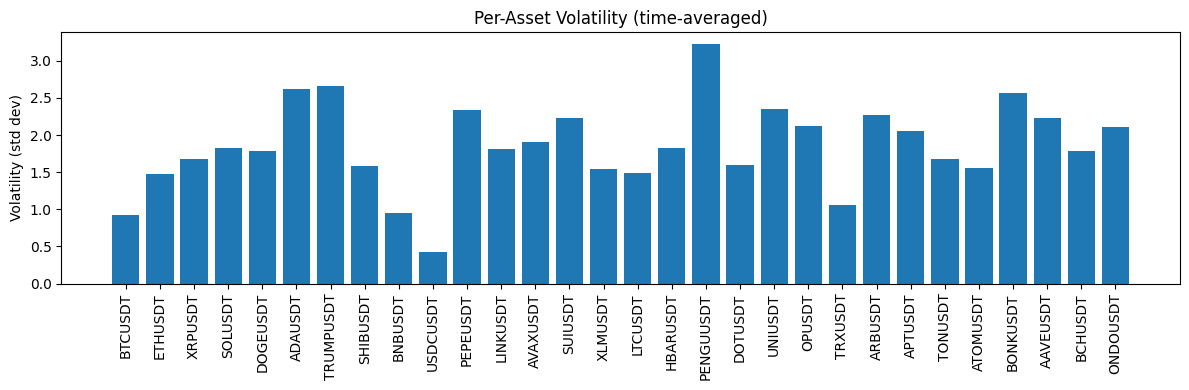

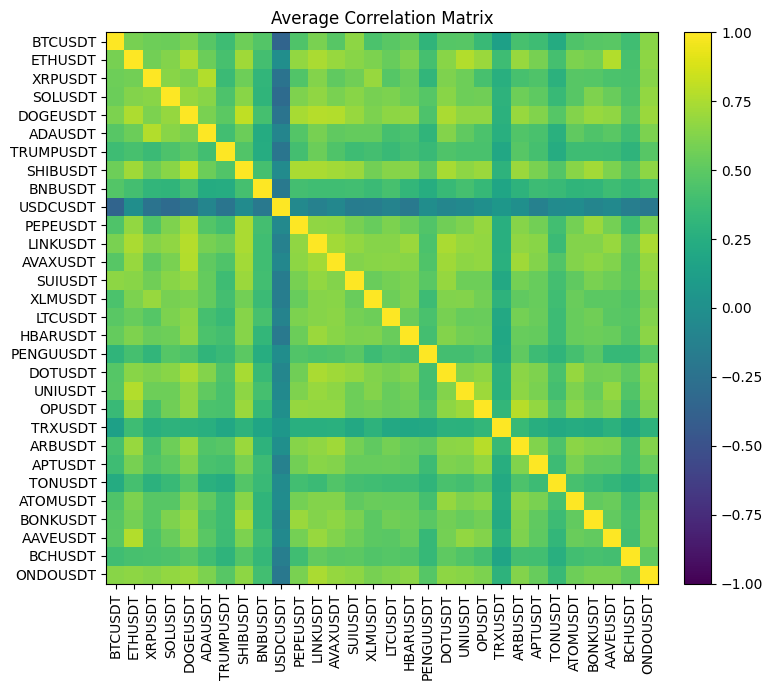

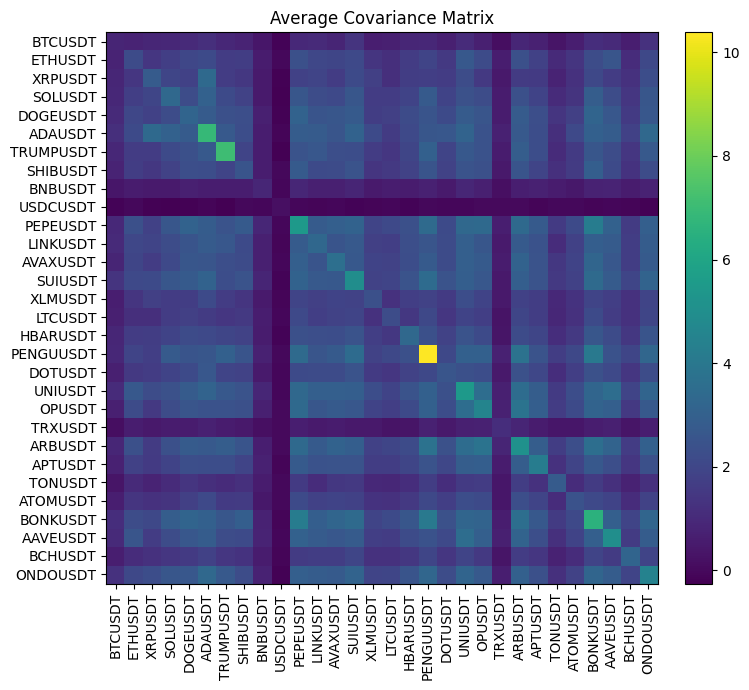

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# -------- paths & meta --------
base_path = "/content/drive/MyDrive/joint"
h = "1"
asset_names = list_crypto.copy()              # ensure this is defined: length S

# -------- load saved outputs --------
# L_all = np.load(f"{base_path}/joint_{h}_test_cholesky.npy")   # [T, S, S]
# means = np.load(f"{base_path}/joint_{h}_test_means.npy")      # [T, S] (optional)
# targets = np.load(f"{base_path}/joint_{h}_test_targets.npy")  # [T, S] (optional)

L_all = np.array(all_return).copy()   # [T, S, S]
means = np.vstack(all_preds).copy()     # [T, S] (optional)
targets = np.vstack(all_targets).copy()  # [T, S] (optional)

T, S, _ = L_all.shape
print("Loaded:", L_all.shape)

# -------- build covariances and vols --------
# Sigma_t = L_t @ L_t.T for each t
Sigma_all = np.einsum("tij,tkj->tik", L_all, L_all)   # [T, S, S]

# Time-averaged covariance & correlation
Sigma_mean = Sigma_all.mean(axis=0)                   # [S, S]

# Volatilities (sqrt of variances)
vols = np.sqrt(np.diag(Sigma_mean))                   # [S]
predicted_vol = []
for i in range(Sigma_all.shape[0]):
  predicted_vol.append(np.sqrt(np.diag(Sigma_all[i])))
predicted_vol = np.vstack(predicted_vol)

# Correlation: C = D^{-1/2} Sigma D^{-1/2}
D_inv_sqrt = np.diag(1.0 / np.clip(vols, 1e-12, None))
Corr_mean = D_inv_sqrt @ Sigma_mean @ D_inv_sqrt      # [S, S]

print("Volatilities:")
for i, a in enumerate(asset_names):
    print(f"{a:>8s}: {vols[i]:.6f}")

# -------- save numeric artifacts (optional) --------
np.save(f"{base_path}/joint_{h}_test_cov_mean.npy", Sigma_mean)
np.save(f"{base_path}/joint_{h}_test_corr_mean.npy", Corr_mean)
np.save(f"{base_path}/joint_{h}_test_vols.npy", vols)

# -------- plotting: volatility bar + heatmaps --------
# 1) Volatility bar chart
plt.figure(figsize=(12, 4))
idx = np.arange(S)
plt.bar(idx, vols)
plt.xticks(idx, asset_names, rotation=90)
plt.ylabel("Volatility (std dev)")
plt.title("Per-Asset Volatility (time-averaged)")
plt.tight_layout()
plt.show()

# 2) Correlation heatmap
plt.figure(figsize=(8, 7))
im = plt.imshow(Corr_mean, interpolation="none", aspect="equal", vmin=-1.0, vmax=1.0)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(np.arange(S), asset_names, rotation=90)
plt.yticks(np.arange(S), asset_names)
plt.title("Average Correlation Matrix")
plt.tight_layout()
plt.show()

# 3) (optional) Covariance heatmap
plt.figure(figsize=(8, 7))
im2 = plt.imshow(Sigma_mean, interpolation="none", aspect="equal")
plt.colorbar(im2, fraction=0.046, pad=0.04)
plt.xticks(np.arange(S), asset_names, rotation=90)
plt.yticks(np.arange(S), asset_names)
plt.title("Average Covariance Matrix")
plt.tight_layout()
plt.show()


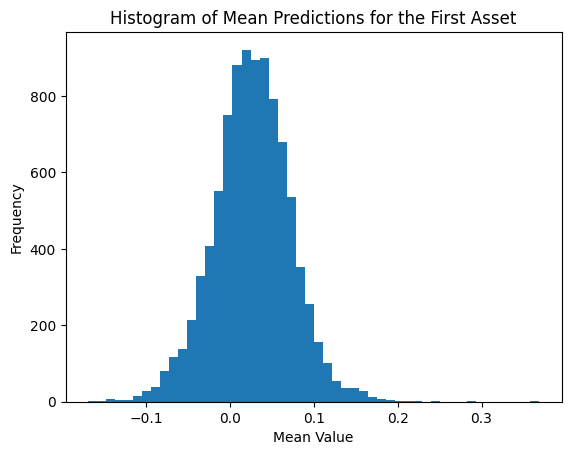

In [46]:
import matplotlib.pyplot as plt

plt.hist(means[:, 2], bins=50)
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Predictions for the First Asset')
plt.show()


Rolling corrs: (9142, 30, 30)


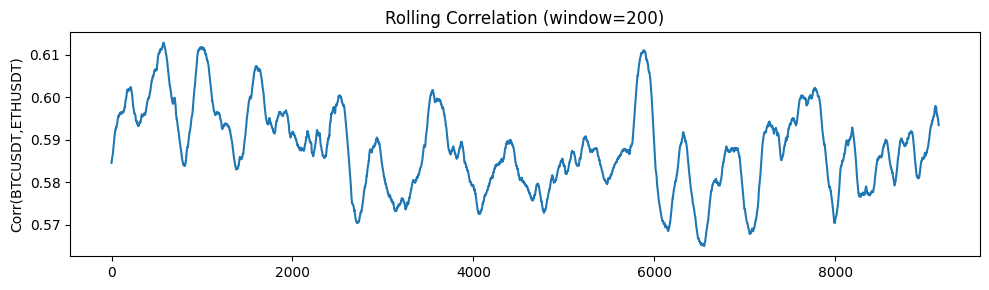

In [47]:
# Rolling window correlation (window in timesteps)
W = 200  # e.g., 200 mins — tune to your frequency
rolling_corrs = []  # list of [S,S] matrices
for t0 in range(0, max(1, T - W + 1)):
    Sigma_win = Sigma_all[t0:t0+W].mean(axis=0)   # [S,S]
    vols_win = np.sqrt(np.diag(Sigma_win))
    D_inv_sqrt_win = np.diag(1.0 / np.clip(vols_win, 1e-12, None))
    C_win = D_inv_sqrt_win @ Sigma_win @ D_inv_sqrt_win
    rolling_corrs.append(C_win)

rolling_corrs = np.stack(rolling_corrs, axis=0)  # [T-W+1, S, S]
print("Rolling corrs:", rolling_corrs.shape)

# Example: plot the rolling correlation of a pair (i,j)
i, j = 0, 1
pair_series = rolling_corrs[:, i, j]
plt.figure(figsize=(10, 3))
plt.plot(pair_series)
plt.ylabel(f"Corr({asset_names[i]},{asset_names[j]})")
plt.title(f"Rolling Correlation (window={W})")
plt.tight_layout()
plt.show()


Creating Predicted Volatility and Predicted Covariance

In [48]:
# -------- build covariances and vols --------
# Sigma_t = L_t @ L_t.T for each t
Sigma_all = np.einsum("tij,tkj->tik", L_all, L_all)   # [T, S, S]

predicted_vol = []
for i in range(Sigma_all.shape[0]):
  predicted_vol.append(np.sqrt(np.diag(Sigma_all[i])))
predicted_vol = np.vstack(predicted_vol)

predicted_corr = []
for i in range(Sigma_all.shape[0]):
  vols = np.sqrt(np.diag(Sigma_all[i]))
  D_inv_sqrt = np.diag(1.0 / np.clip(vols, 1e-12, None))
  Corr_mean = D_inv_sqrt @ Sigma_all[i] @ D_inv_sqrt      # [S, S]
  predicted_corr.append(Corr_mean)
predicted_corr = np.array(predicted_corr)

predicted_return = means.copy()

In [50]:
predicted_vol.shape

(9341, 30)

In [51]:
means.shape

(9341, 30)

In [52]:
predicted_corr.shape

(9341, 30, 30)

In [53]:
df_test = data_test.iloc[my_seq_len:-shifted_window][['dateTime']+[x for x in data_test.columns if 'dateTime' not in x]].reset_index().drop('index',axis=1)

for i in range(len(list_crypto)):
  df_test['pred_vol_'+list_crypto[i]] = predicted_vol[:,i]

In [54]:
df_test[['BTCUSDT_volatility',  'pred_vol_BTCUSDT','ETHUSDT_volatility',  'pred_vol_ETHUSDT']].corr()

,BTCUSDT_volatility,pred_vol_BTCUSDT,ETHUSDT_volatility,pred_vol_ETHUSDT
BTCUSDT_volatility,1.000000,-0.172220,0.572177,-0.045153
pred_vol_BTCUSDT,-0.172220,1.000000,-0.228097,-0.032744
ETHUSDT_volatility,0.572177,-0.228097,1.000000,-0.075180
pred_vol_ETHUSDT,-0.045153,-0.032744,-0.075180,1.000000


In [57]:
df_test.shape, len(means[:, 2])

((9341, 277), 9341)

Optimizer Functions

In [100]:
import numpy as np
import cvxpy as cp
from random import sample

def build_cov_matrix(std, corr):
    """Cov_ij = corr_ij * std_i * std_j"""
    return np.outer(std, std) * corr

def _solve_mvo_l1(mu, cov, gamma):
    """
    Maximize mu^T x - 0.5 * gamma * x^T cov x
    s.t. x = x+ - x-, x+>=0, x->=0, sum(x+ + x-) = 1   (=> ||x||_1 = 1)
    """
    n = len(mu)
    x_pos = cp.Variable(n, nonneg=True)
    x_neg = cp.Variable(n, nonneg=True)
    x = x_pos - x_neg

    obj = cp.Maximize(mu @ x - 0.5 * gamma * cp.quad_form(x, cov))
    cons = [cp.sum(x_pos + x_neg) == 1]  # exact L1 = 1
    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.SCS)
    return x.value

def optimize_mvo(stats, gamma=3.0):
    mu, std, corr = stats['mean'], stats['std'], stats['corr']
    cov = build_cov_matrix(std, corr)
    return _solve_mvo_l1(mu, cov, gamma)

def optimize_method1(stats, gamma=3.0, theta=0.90):
    """
    1) Solve MVO under L1=1 to get eps (utility)
    2) Minimize ||x||_2^2 subject to utility >= theta * eps and L1=1 (via x = x+-x-)
    """
    mu, std, corr = stats['mean'], stats['std'], stats['corr']
    cov = build_cov_matrix(std, corr)
    n = len(mu)

    # --- Stage 1: baseline utility eps under L1=1
    w0 = _solve_mvo_l1(mu, cov, gamma)
    eps = float(mu @ w0 - 0.5 * gamma * (w0.T @ cov @ w0))

    # --- Stage 2: minimize ||x||_2^2 with same L1=1 and utility floor
    x_pos = cp.Variable(n, nonneg=True)
    x_neg = cp.Variable(n, nonneg=True)
    x = x_pos - x_neg

    util_constr = (mu @ x - 0.5 * gamma * cp.quad_form(x, cov)) >= theta * eps
    obj = cp.Minimize(cp.sum_squares(x))
    cons = [cp.sum(x_pos + x_neg) == 1, util_constr]
    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.SCS)
    return x.value

def _solve_mvo_sub_l1(mu_sub, cov_sub, gamma):
    m = len(mu_sub)
    x_pos = cp.Variable(m, nonneg=True)
    x_neg = cp.Variable(m, nonneg=True)
    x = x_pos - x_neg
    obj = cp.Maximize(mu_sub @ x - 0.5 * gamma * cp.quad_form(x, cov_sub))
    cons = [cp.sum(x_pos + x_neg) == 1]
    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.SCS)
    return x.value

def optimize_method2(stats, gamma=3.0, num_resamples=100, subset_size=5):
    mu, std, corr = stats['mean'], stats['std'], stats['corr']
    cov = build_cov_matrix(std, corr)
    n = len(mu)
    w_acc = np.zeros(n)

    for _ in range(num_resamples):
        subset = sorted(sample(range(n), subset_size))
        mu_sub  = mu[subset]
        cov_sub = cov[np.ix_(subset, subset)]
        try:
            w_sub = _solve_mvo_sub_l1(mu_sub, cov_sub, gamma)
        except Exception:
            continue
        w_full = np.zeros(n)
        for i, wi in zip(subset, w_sub):
            w_full[i] = wi
        w_acc += w_full

    return w_acc / max(1, num_resamples)


Creating dataset for test based on one step return

In [68]:
df_test = data.iloc[100:-100].copy()
df_test = df_test[df_test['day'].isin(list_days_test)]
df_test = df_test[['dateTime']+[x+'_'+'close' for x in list_crypto]]
df_test = df_test.set_index('dateTime')
df_test = 100*df_test.pct_change().shift(-1)
df_test = df_test.rename(columns={x:x.replace('close','return') for x in df_test.columns})
# df_test = df_test.iloc[my_seq_len:-shifted_window].copy()
df_test.iloc[0:0+my_seq_len]

,BTCUSDT_return,ETHUSDT_return,XRPUSDT_return,SOLUSDT_return,DOGEUSDT_return,ADAUSDT_return,TRUMPUSDT_return,SHIBUSDT_return,BNBUSDT_return,USDCUSDT_return,...,OPUSDT_return,TRXUSDT_return,ARBUSDT_return,APTUSDT_return,TONUSDT_return,ATOMUSDT_return,BONKUSDT_return,AAVEUSDT_return,BCHUSDT_return,ONDOUSDT_return
dateTime,,,,,,,,,,,,,,,,,,,,,
2025-07-23 00:00:00,-0.017172,-0.026474,0.056481,0.068239,-0.003713,-0.111062,-0.432199,0.000000,0.383560,0.010005,...,-0.212819,-0.028492,0.000000,-0.153925,0.129067,-0.137255,-0.162338,0.100337,-0.045703,-0.070597
2025-07-23 00:03:00,-0.062781,0.028353,-0.112899,-0.126644,-0.048270,-0.044474,0.072346,-0.064935,0.118930,-0.010004,...,-0.263455,0.009500,-0.124896,0.201879,0.128901,0.019635,-0.135501,-0.045268,-0.110499,-0.485694
2025-07-23 00:06:00,-0.028115,-0.044122,-0.155411,-0.160944,-0.148594,-0.033370,-0.009037,-0.064977,0.180711,0.000000,...,0.138365,0.155152,0.208420,0.012821,-0.233519,0.157048,-0.624152,-0.067933,0.133509,-0.106487
2025-07-23 00:09:00,-0.032629,-0.036918,0.019810,-0.161204,0.055806,-0.133526,-0.063263,-0.130039,0.409965,0.000000,...,0.087929,-0.148588,-0.083195,-0.148338,0.006002,-0.117601,-0.163845,-0.126246,-0.142854,-0.151017
2025-07-23 00:12:00,0.052007,0.090456,0.138645,0.161464,0.226816,0.222841,0.226081,0.260417,0.084171,-0.010005,...,0.263554,-0.025329,0.187344,0.256768,0.003001,0.372841,0.492341,0.187988,0.268951,0.213523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-23 03:45:00,-0.033285,-0.091556,0.091625,-0.014898,0.068221,0.022712,-0.063822,0.066007,0.370445,0.000000,...,0.000000,-0.211563,-0.063573,0.000000,0.024410,0.039596,-0.162426,-0.117582,-0.078174,-0.009082
2025-07-23 03:48:00,-0.030767,0.054126,0.008582,0.054634,0.121198,0.056767,0.072986,0.065963,-0.061513,0.000000,...,0.127616,0.034808,0.148431,0.072257,-0.042706,0.079161,0.027115,0.071940,0.499943,0.045413
2025-07-23 03:51:00,0.016948,-0.189340,0.005721,0.004964,0.034046,-0.034041,-0.072933,0.000000,-0.035172,0.010006,...,-0.012745,-0.006327,-0.063519,0.000000,-0.042725,-0.079098,-0.081323,-0.114368,-0.068353,-0.045393


Getting Weight for each timestamp based on predictions (3 methods)

In [136]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

alpha = 0.6
list_weight_m0 = []
list_weight_m1 = []
list_weight_m2 = []

# data_test_new = data_test.set_index('dateTime')
return_columns = [x for x in df_test.columns if ('return' in x and '_prev_return' not in x and len(x)>6)]
for i in range(0, len(df_test)-2*my_seq_len, shifted_window):
    end_time = df_test.index[i+my_seq_len-1]
    start_time = end_time - pd.Timedelta(minutes=4*60)
    past_returns_window = df_test.loc[start_time:end_time, return_columns]
    past_corr = past_returns_window.corr().to_numpy()
    past_mu  = past_returns_window.sum().to_numpy()
    past_vol = past_returns_window.std().to_numpy()
    past_vol[past_vol < 1e-8] = 1e-8

    weighted_mu  = (1 - alpha) * past_mu  + alpha * predicted_return[i]
    weighted_vol = (1 - alpha) * past_vol + alpha * predicted_vol[i]
    weighted_corr = (1 - alpha) * past_corr  + alpha * predicted_corr[i]

    stats = {
        "mean": weighted_mu,
        "std":  weighted_vol,
        "corr": past_corr
    }

    predicted_w_m0 = optimize_mvo(stats, gamma=3.0)
    predicted_w_m1 = optimize_method1(stats, gamma=3.0, theta=0.90)
    predicted_w_m2 = optimize_method2(
        stats,
        gamma=3.0,
        num_resamples=20,
        subset_size=5
    )

    list_weight_m0.append({'dateTime':df_test.index[i+my_seq_len]} | {list_crypto[ji]:predicted_w_m0[ji] for ji in range(len(list_crypto))})
    list_weight_m1.append({'dateTime':df_test.index[i+my_seq_len]} | {list_crypto[ji]:predicted_w_m1[ji] for ji in range(len(list_crypto))})
    list_weight_m2.append({'dateTime':df_test.index[i+my_seq_len]} | {list_crypto[ji]:predicted_w_m2[ji] for ji in range(len(list_crypto))})

    # break

In [137]:
df_weight0 = pd.DataFrame(list_weight_m0)
df_weight0 = df_weight0.set_index('dateTime')
df_weight1 = pd.DataFrame(list_weight_m1)
df_weight1 = df_weight1.set_index('dateTime')
df_weight2 = pd.DataFrame(list_weight_m2)
df_weight2 = df_weight2.set_index('dateTime')
df_weight0.sum(axis=0)

,0
BTCUSDT,-5.496033e-02
ETHUSDT,3.605541e-01
XRPUSDT,1.496129e-01
SOLUSDT,-1.971105e+00
DOGEUSDT,-1.288278e+00
ADAUSDT,1.251771e+00
TRUMPUSDT,2.584662e-01
SHIBUSDT,-1.377098e-01
BNBUSDT,1.305868e+00
USDCUSDT,-8.791051e-07


Creating Portfolio Dataframe

In [138]:
df_portfolio0 = df_test.iloc[80:].merge(df_weight0, left_index=True, right_index=True, how='left')
df_portfolio0 = df_portfolio0.fillna(method='ffill')
list_portfolio = []
for x in list_crypto:
  df_portfolio0[x+'_value'] = df_portfolio0[x+'_return']*df_portfolio0[x]
  list_portfolio.append(x+'_value')
df_portfolio1 = df_test.iloc[80:].merge(df_weight1, left_index=True, right_index=True, how='left')
df_portfolio1 = df_portfolio1.fillna(method='ffill')
for x in list_crypto:
  df_portfolio1[x+'_value'] = df_portfolio1[x+'_return']*df_portfolio1[x]
df_portfolio2 = df_test.iloc[80:].merge(df_weight2, left_index=True, right_index=True, how='left')
df_portfolio2 = df_portfolio2.fillna(method='ffill')
for x in list_crypto:
  df_portfolio2[x+'_value'] = df_portfolio2[x+'_return']*df_portfolio2[x]

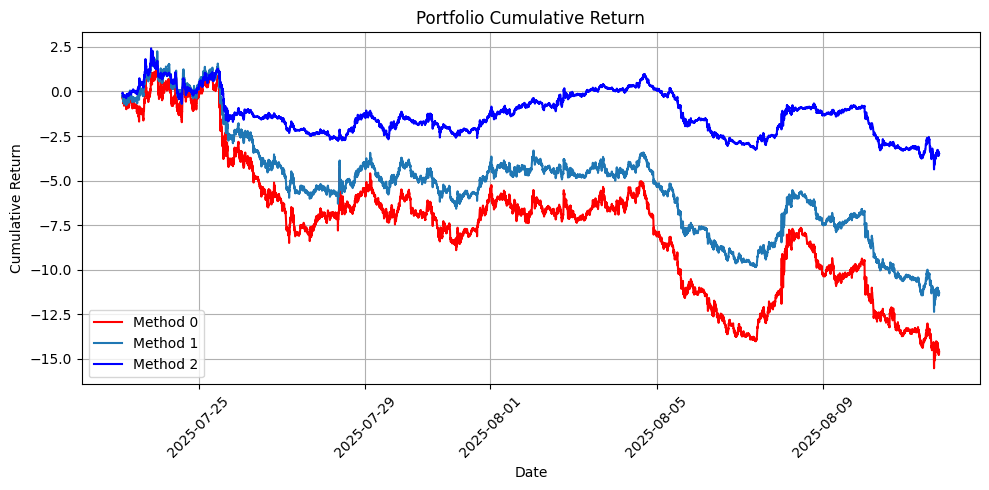

In [139]:
df_portfolio0['portfolio'] = df_portfolio0[list_portfolio].sum(axis=1).cumsum()
df_portfolio1['portfolio'] = df_portfolio1[list_portfolio].sum(axis=1).cumsum()
df_portfolio2['portfolio'] = df_portfolio2[list_portfolio].sum(axis=1).cumsum()

plt.figure(figsize=(10, 5))

# Add labels here
plt.plot(df_portfolio0.index, df_portfolio0['portfolio'], color='red', label='Method 0')
plt.plot(df_portfolio1.index, df_portfolio1['portfolio'], label='Method 1')
plt.plot(df_portfolio2.index, df_portfolio2['portfolio'], color='blue', label='Method 2')

# Add legend
plt.legend(loc='best')

# Add grid
plt.grid(True)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio Cumulative Return')

plt.tight_layout()
plt.show()


In [133]:
df_portfolio0.to_csv('joint0.csv')

In [134]:
df_portfolio2.to_csv('joint2.csv')

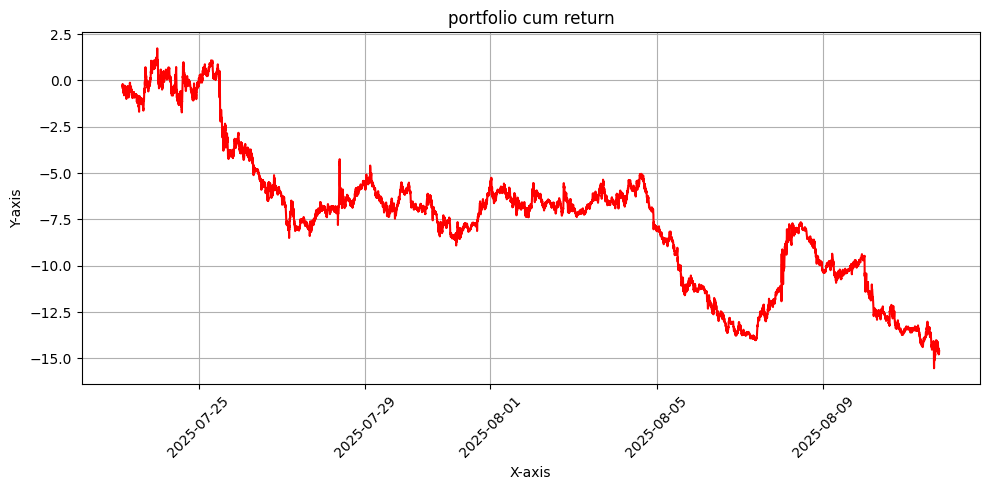

In [129]:
df_portfolio0['portfolio'] = df_portfolio0[list_portfolio].sum(axis=1).cumsum()
df_portfolio2['portfolio'] = df_portfolio2[list_portfolio].sum(axis=1).cumsum()

plt.figure(figsize=(10, 5))  # Optional: adjust figure size

plt.plot(list(df_portfolio0.index), df_portfolio0['portfolio'].to_list(), color='red')  # You can remove `marker` if not needed

# Add grid
plt.grid(True)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Optional: Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('portfolio cum return')

plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()


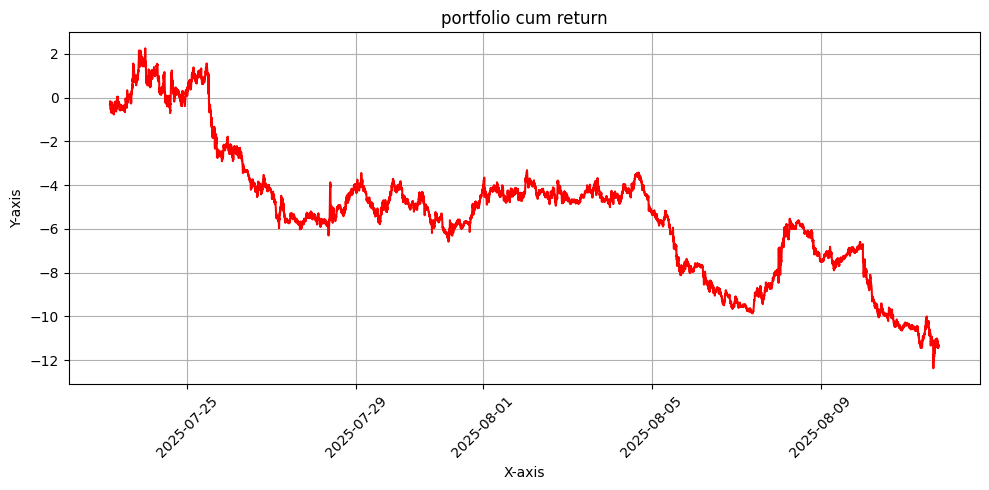

In [140]:
df_portfolio0['portfolio'] = df_portfolio0[list_portfolio].sum(axis=1).cumsum()
df_portfolio2['portfolio'] = df_portfolio2[list_portfolio].sum(axis=1).cumsum()

plt.figure(figsize=(10, 5))  # Optional: adjust figure size

plt.plot(list(df_portfolio1.index), df_portfolio1['portfolio'].to_list(), color='red')  # You can remove `marker` if not needed

# Add grid
plt.grid(True)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Optional: Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('portfolio cum return')

plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()


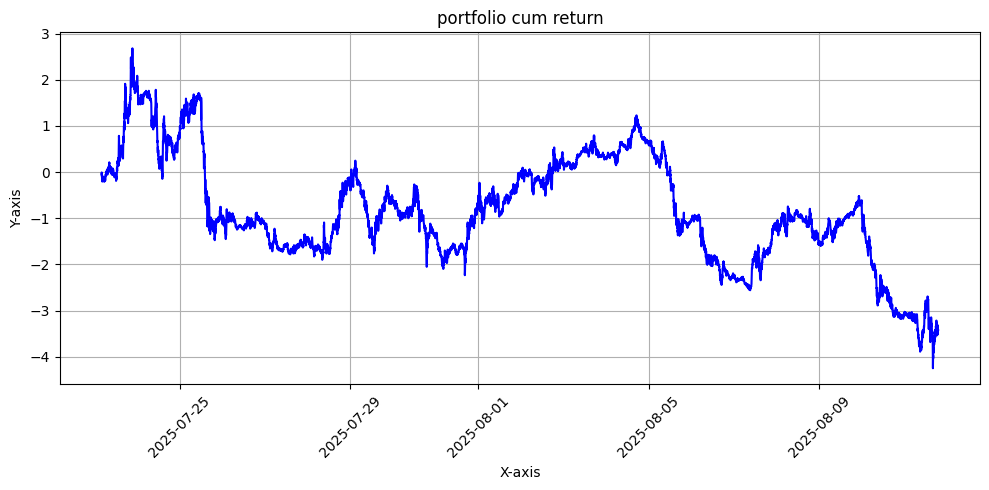

In [130]:
df_portfolio0['portfolio'] = df_portfolio0[list_portfolio].sum(axis=1).cumsum()
df_portfolio2['portfolio'] = df_portfolio2[list_portfolio].sum(axis=1).cumsum()

plt.figure(figsize=(10, 5))  # Optional: adjust figure size

plt.plot(list(df_portfolio2.index), df_portfolio2['portfolio'].to_list(), color='blue')  # You can remove `marker` if not needed

# Add grid
plt.grid(True)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Optional: Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('portfolio cum return')

plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()
